In [4]:
#!/usr/bin/env python3 -u
# Copyright (c) 2017-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the LICENSE file in
# the root directory of this source tree.
from __future__ import print_function

import argparse
import csv
import os

import numpy as np
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import models
from utils import progress_bar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import MixingFunctions
import sys
import importlib  
from matplotlib.pyplot import figure

# %cd ../../

function = importlib.import_module("Mixing-Augmentation.filters.attention.function")
attribution_methods = importlib.import_module("Mixing-Augmentation.filters.attention.filter_code.code.saliency.attribution_methods")
models_attention = importlib.import_module("Mixing-Augmentation.filters.attention.filter_code.code.models_attention")
filter_env = importlib.import_module("Mixing-Augmentation.filters.Environment.environment_apply")

importlib.reload(function)
importlib.reload(attribution_methods)
importlib.reload(models)
importlib.reload(filter_env)
# importlib.reload(MixingFunctions)


params = {
    "lr": .01,
    "resume": False,
    "model": "ResNet18",
    "name": "Attention-NoMix-NoAdvs",
    "seed": 10,
    "batch_size": 128,
    "decay": 5e-4, 
    "augment": True,
    "epoch": 200,
#     "no_augment": False,
    "alpha": 1.,
}

%config Completer.use_jedi = False

In [14]:
!pwd

/home/m25dehgh/testing_codes/NNs


In [5]:



# checkpoint = torch.load('./checkpoint/ckpt.t7' + params["name"] + '_'
#                             + str(params["seed"]), map_location='cpu')

# net_VerticalMix_2Sets_SampEps_32_10 = checkpoint['net']
# net_VerticalMix_2Sets_SampEps_32_10.cuda()

/home/m25dehgh/testing_codes/NNs


# Loading Data

In [28]:



use_cuda = torch.cuda.is_available()

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

if params["seed"] != 0:
    torch.manual_seed(params["seed"])

# Data
print('==> Preparing data..')
if params["augment"]:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])
else:
    print("no augmentation")
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(root='/home/m25dehgh/testing_codes/NNs/data', train=True, download=False,
                            transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=params["batch_size"],
                                          shuffle=True, num_workers=8)

testset = datasets.CIFAR10(root='/home/m25dehgh/testing_codes/NNs/data', train=False, download=False,
                           transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=8)

==> Preparing data..


# Creating Loss Funciton 

In [32]:
criterion = nn.CrossEntropyLoss()

# Helping functions

# Training the model

In [11]:
model_names = [
    'ckpt.t7Attention-LinearMix-2Sets-128-AdvsTrain-Eps(.32, .08)_10',
    'ckpt.t7Attention-NoMix-NoAdvs_10',
    'ckpt.t7ERM-128-WithAug_10', # vanilla trianed model
    'ckpt.t7EnvFilter-LinearMix-2Sets-128-AdvsTrain-Eps(.32, .08)_10',
    'ckpt.t7EnvFilter-NoMix-NoAdvs_10',
    'ckpt.t7HorizontalMix-2Sets-128-AdvsTrain-Eps(.32, .08)_10',
    'ckpt.t7HorizontalMix-2Sets-128-NoAdvs_10',
    'ckpt.t7HorizontalMix-3Sets-128-AdvsTrain-Eps(.32, .08)_10',
    'ckpt.t7HorizontalMix-3Sets-128-NoAdvs_10',
    'ckpt.t7LinearMix-3Sets-128-AdvsTrain-Eps(.32, .08)_10',
    'ckpt.t7LinearMix-3Sets-128-NoAdvs_10',
    'ckpt.t7VerticalMix-2Sets-128-AdvsTrain-Eps(.32, .08)_10',
    'ckpt.t7VerticalMix-2Sets-128-NoAdvs_10',
    'ckpt.t7VerticalMix-3Sets-128-AdvsTrain-Eps(.32, .08)_10',
    'ckpt.t7VerticalMix-3Sets-128-NoAdvs_10',
    'ckpt.t7mixup-128-AdvsTrain-Eps(.32, .08)_10',
    'ckpt.t7mixup-128-AdvsTrain-Eps0.05_10',
    'ckpt.t7mixup-128-AdvsTrain-Eps0.25_10',
    'ckpt.t7mixup-128-AdvsTrain-Eps0.35_10',
    'ckpt.t7mixup-128-AdvsTrain-Eps0.45_10',
    'ckpt.t7mixup-128-AdvsTrain-EpsBeta(1,1)_10',
    'ckpt.t7mixup-128-NoAdvs_10', # vanilla linear mixing model
    'ckpt.t7nomixup-128-NormalAdvsTrain0.35_10'] # vanilla defence goodflow 2014

In [17]:
params = {
    "lr": .01,
    "resume": False,
    "model": "ResNet18",
    "name": "Attention-NoMix-NoAdvs",
    "seed": 10,
    "batch_size": 128,
    "decay": 5e-4, 
    "augment": True,
    "epoch": 200,
#     "no_augment": False,
    "alpha": 1.,
}

# errs = {}

models = {}
    

for name in model_names:
    

    checkpoint = torch.load("./checkpoint/" + name, map_location='cpu')

    models[name] = checkpoint['net']

In [105]:
name = "ckpt.t7EnvFilter-LinearMix-2Sets-128-AdvsTrain-Eps(.32, .08)_10"
chp = torch.load("./checkpoint/" + name, map_location='cpu')
models[name] = chp['net']
errs[name], eps_list = robust_eval_range(models[name])

100it [00:09, 10.01it/s]

incorrects are: 1359 
total is: 10000 
Top-1 error is 13.589999198913574



100it [00:09, 10.13it/s]

incorrects are: 2680 
total is: 10000 
Top-1 error is 26.799999237060547



100it [00:09, 10.12it/s]

incorrects are: 1091 
total is: 10000 
Top-1 error is 10.90999984741211



100it [00:09, 10.04it/s]

incorrects are: 1107 
total is: 10000 
Top-1 error is 11.069999694824219



100it [00:10,  9.97it/s]

incorrects are: 1361 
total is: 10000 
Top-1 error is 13.609999656677246



100it [00:09, 10.15it/s]

incorrects are: 1626 
total is: 10000 
Top-1 error is 16.260000228881836



100it [00:10,  9.96it/s]

incorrects are: 1844 
total is: 10000 
Top-1 error is 18.439998626708984



100it [00:09, 10.12it/s]


incorrects are: 2078 
total is: 10000 
Top-1 error is 20.779998779296875


100it [00:09, 10.23it/s]

incorrects are: 2359 
total is: 10000 
Top-1 error is 23.59000015258789



100it [00:10,  9.92it/s]

incorrects are: 2638 
total is: 10000 
Top-1 error is 26.3799991607666



100it [00:10,  9.97it/s]

incorrects are: 3002 
total is: 10000 
Top-1 error is 30.01999855041504



100it [00:09, 10.21it/s]

incorrects are: 3468 
total is: 10000 
Top-1 error is 34.68000030517578



100it [00:09, 10.17it/s]

incorrects are: 4101 
total is: 10000 
Top-1 error is 41.0099983215332



100it [00:10,  9.97it/s]

incorrects are: 4819 
total is: 10000 
Top-1 error is 48.189998626708984



100it [00:09, 10.01it/s]

incorrects are: 5538 
total is: 10000 
Top-1 error is 55.37999725341797


In [109]:
# del models['ckpt.t7EnvFilter-LinearMix-2Sets-128-AdvsTrain-Eps(.32, .08)_10']
# to_acc_tensor([eval_robust(models['ckpt.t7ERM-128-WithAug_10'], 0)])
for name in selected_errs:
    print(name, " clean acc is:", to_acc_tensor([eval_robust(models[name], 0)]))
    print(name, " on .25 advs noise acc is:", to_acc_tensor([eval_robust(models[name], 0.25)]))
    print("===================================================================")

100it [00:09, 10.68it/s]

incorrects are: 1114 
total is: 10000 
Top-1 error is 11.139999389648438
ckpt.t7Attention-LinearMix-2Sets-128-AdvsTrain-Eps(.32, .08)_10  clean acc is: tensor([88.8600])



100it [00:09, 10.79it/s]

incorrects are: 3546 
total is: 10000 
Top-1 error is 35.459999084472656
ckpt.t7Attention-LinearMix-2Sets-128-AdvsTrain-Eps(.32, .08)_10  on .25 advs noise acc is: tensor([64.5400])



100it [00:09, 10.60it/s]

incorrects are: 620 
total is: 10000 
Top-1 error is 6.199999809265137
ckpt.t7Attention-NoMix-NoAdvs_10  clean acc is: tensor([93.8000])



100it [00:09, 10.67it/s]

incorrects are: 8687 
total is: 10000 
Top-1 error is 86.8699951171875
ckpt.t7Attention-NoMix-NoAdvs_10  on .25 advs noise acc is: tensor([13.1300])



100it [00:09, 10.67it/s]

incorrects are: 1359 
total is: 10000 
Top-1 error is 13.589999198913574
ckpt.t7EnvFilter-LinearMix-2Sets-128-AdvsTrain-Eps(.32, .08)_10  clean acc is: tensor([86.4100])



100it [00:09, 10.58it/s]

incorrects are: 1894 
total is: 10000 
Top-1 error is 18.939998626708984
ckpt.t7EnvFilter-LinearMix-2Sets-128-AdvsTrain-Eps(.32, .08)_10  on .25 advs noise acc is: tensor([81.0600])



100it [00:09, 10.56it/s]

incorrects are: 568 
total is: 10000 
Top-1 error is 5.679999828338623
ckpt.t7EnvFilter-NoMix-NoAdvs_10  clean acc is: tensor([94.3200])



100it [00:09, 10.64it/s]


incorrects are: 8120 
total is: 10000 
Top-1 error is 81.19999694824219
ckpt.t7EnvFilter-NoMix-NoAdvs_10  on .25 advs noise acc is: tensor([18.8000])


100it [00:09, 10.70it/s]

incorrects are: 962 
total is: 10000 
Top-1 error is 9.619999885559082
ckpt.t7mixup-128-AdvsTrain-Eps(.32, .08)_10  clean acc is: tensor([90.3800])



100it [00:09, 10.52it/s]

incorrects are: 290 
total is: 10000 
Top-1 error is 2.8999998569488525
ckpt.t7mixup-128-AdvsTrain-Eps(.32, .08)_10  on .25 advs noise acc is: tensor([97.1000])



100it [00:09, 10.52it/s]

incorrects are: 723 
total is: 10000 
Top-1 error is 7.230000019073486
ckpt.t7nomixup-128-NormalAdvsTrain0.35_10  clean acc is: tensor([92.7700])



100it [00:09, 10.61it/s]

incorrects are: 6989 
total is: 10000 
Top-1 error is 69.88999938964844
ckpt.t7nomixup-128-NormalAdvsTrain0.35_10  on .25 advs noise acc is: tensor([30.1100])


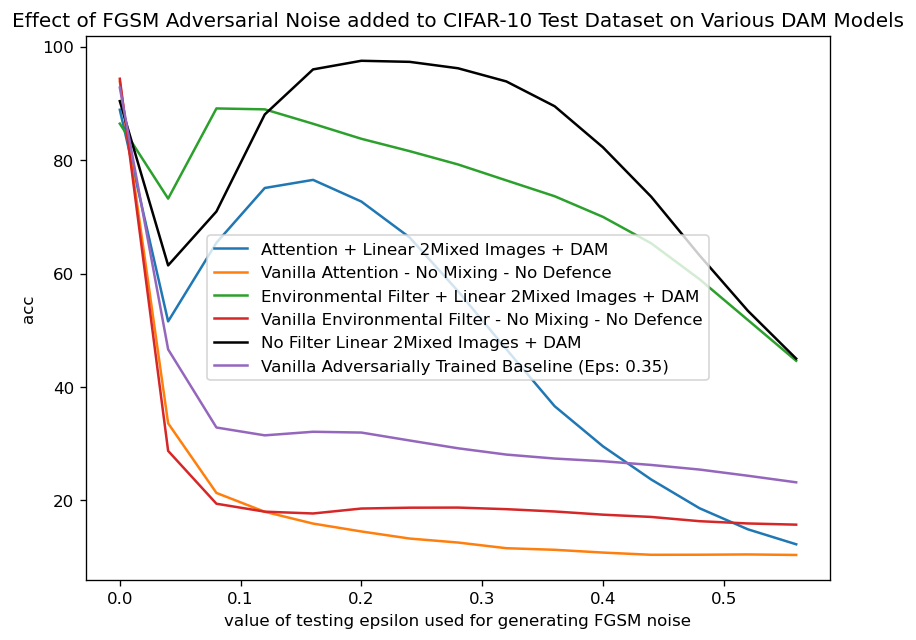

In [113]:
# selected_errs = [
# #     'ckpt.t7mixup-128-NoAdvs_10',
#     'ckpt.t7mixup-128-AdvsTrain-Eps(.32, .08)_10',
# #     'ckpt.t7LinearMix-3Sets-128-NoAdvs_10',
#     'ckpt.t7LinearMix-3Sets-128-AdvsTrain-Eps(.32, .08)_10',
# #     'ckpt.t7HorizontalMix-2Sets-128-NoAdvs_10',
#     'ckpt.t7HorizontalMix-2Sets-128-AdvsTrain-Eps(.32, .08)_10',
# #     'ckpt.t7HorizontalMix-3Sets-128-NoAdvs_10',
#     'ckpt.t7HorizontalMix-3Sets-128-AdvsTrain-Eps(.32, .08)_10',
# #     'ckpt.t7VerticalMix-2Sets-128-NoAdvs_10',
#     'ckpt.t7VerticalMix-2Sets-128-AdvsTrain-Eps(.32, .08)_10',
# #     'ckpt.t7VerticalMix-3Sets-128-NoAdvs_10',
#     'ckpt.t7VerticalMix-3Sets-128-AdvsTrain-Eps(.32, .08)_10',
#     'ckpt.t7nomixup-128-NormalAdvsTrain0.35_10',
#                 ]

selected_errs = [
    'ckpt.t7Attention-LinearMix-2Sets-128-AdvsTrain-Eps(.32, .08)_10',
    'ckpt.t7Attention-NoMix-NoAdvs_10',
    'ckpt.t7EnvFilter-LinearMix-2Sets-128-AdvsTrain-Eps(.32, .08)_10',
    'ckpt.t7EnvFilter-NoMix-NoAdvs_10',
    'ckpt.t7mixup-128-AdvsTrain-Eps(.32, .08)_10',
    'ckpt.t7nomixup-128-NormalAdvsTrain0.35_10',
#     'ckpt.t7mixup-128-NoAdvs_10',

                ]



figure(figsize=(8, 6), dpi=120)

plt.xlabel('value of testing epsilon used for generating FGSM noise'); plt.ylabel('acc');

legends = []
for name in selected_errs:
    if name == 'ckpt.t7mixup-128-AdvsTrain-Eps(.32, .08)_10':
        plt.plot(eps_list, to_acc_tensor(errs[name]), c='black')
    else: 
        plt.plot(eps_list, to_acc_tensor(errs[name]))
    legends.append(name[7:])

plt.title('Effect of FGSM Adversarial Noise added to CIFAR-10 Test Dataset on Various DAM Models')
plt.legend(legends)
# plt.legend(["DAM (Training Eps: 0.35)", "Vanilla Adversarially Trained Baseline (Eps: 0.35)", "Linear Mixup", "Vanilla Classifier"])
legends = [
    'Attention + Linear 2Mixed Images + DAM',
    'Vanilla Attention - No Mixing - No Defence',
    'Environmental Filter + Linear 2Mixed Images + DAM',
    'Vanilla Environmental Filter - No Mixing - No Defence',
    "No Filter - Linear 2Mixed Images + DAM",
    "Vanilla Adversarially Trained Baseline (Eps: 0.35)",
#     'No Filter Linear 2Mixed Images',
                ]
plt.legend(legends)

# Robustness Evaluation

In [33]:
def eval_robust(net, epsilon=0):

    net.to(f'cuda:{net.device_ids[0]}')
    net.eval()
    incorrect = 0
    total = 0
    
    for batch_idx, (normal_inpts, targets) in tqdm(enumerate(testloader)):
        if use_cuda:
            normal_inpts, targets = normal_inpts.cuda(), targets.cuda()
        normal_inpts.requires_grad_(True)
        
        outputs = net(normal_inpts)
        loss = criterion(outputs, targets)
        
        net.zero_grad()
        loss.backward()
        
        
        with torch.no_grad():
            advers_inp = normal_inpts + (epsilon * normal_inpts.grad.sign())
            advers_out = net(advers_inp)

            normal_out = net(normal_inpts)
            _,advs_predicted = torch.max(advers_out.data, 1)
            _,normal_predicted = torch.max(normal_out.data, 1)
    

        total += targets.size(0)
        incorrect += targets.size(0) - advs_predicted.eq(targets.data).sum()
    
    print(f'incorrects are: {incorrect} \ntotal is: {total} \nTop-1 error is {100.*incorrect/total}')
        
    return 100.*incorrect/total


def robust_eval_range(net, points=15, delta=.04):
    eps_list = [i * delta for i in list(range(points))]
    top_one_errs = []
    for i in eps_list:
        top_one_errs.append(eval_robust(net, i))
    return top_one_errs, eps_list

def to_acc_tensor(arr):
    return 100 - torch.cat([i.reshape(1) for i in arr]).cpu()

100it [00:51,  1.94it/s]

incorrects are: 568 
total is: 10000 
Top-1 error is 5.679999828338623


tensor([94.3200])

In [40]:
# for name, model in models.items():
#     errs[name], eps_list = robust_eval_range(model)

100it [00:11,  8.40it/s]

incorrects are: 1114 
total is: 10000 
Top-1 error is 11.139999389648438



100it [00:11,  8.74it/s]

incorrects are: 4844 
total is: 10000 
Top-1 error is 48.439998626708984



100it [00:11,  8.81it/s]

incorrects are: 3458 
total is: 10000 
Top-1 error is 34.57999801635742



100it [00:11,  8.90it/s]

incorrects are: 2493 
total is: 10000 
Top-1 error is 24.93000030517578



100it [00:11,  8.96it/s]

incorrects are: 2350 
total is: 10000 
Top-1 error is 23.5



100it [00:11,  9.09it/s]

incorrects are: 2732 
total is: 10000 
Top-1 error is 27.31999969482422



100it [00:11,  9.09it/s]

incorrects are: 3365 
total is: 10000 
Top-1 error is 33.64999771118164



100it [00:11,  8.95it/s]

incorrects are: 4311 
total is: 10000 
Top-1 error is 43.11000061035156



100it [00:11,  9.09it/s]

incorrects are: 5333 
total is: 10000 
Top-1 error is 53.32999801635742



100it [00:10,  9.10it/s]

incorrects are: 6338 
total is: 10000 
Top-1 error is 63.37999725341797



100it [00:11,  9.07it/s]

incorrects are: 7045 
total is: 10000 
Top-1 error is 70.44999694824219



100it [00:10,  9.23it/s]

incorrects are: 7631 
total is: 10000 
Top-1 error is 76.30999755859375



100it [00:11,  8.96it/s]

incorrects are: 8137 
total is: 10000 
Top-1 error is 81.3699951171875



100it [00:11,  8.94it/s]

incorrects are: 8508 
total is: 10000 
Top-1 error is 85.07999420166016



100it [00:11,  9.04it/s]

incorrects are: 8772 
total is: 10000 
Top-1 error is 87.72000122070312



100it [00:11,  9.03it/s]


incorrects are: 620 
total is: 10000 
Top-1 error is 6.199999809265137


100it [00:11,  8.88it/s]

incorrects are: 6640 
total is: 10000 
Top-1 error is 66.4000015258789



100it [00:11,  9.08it/s]

incorrects are: 7867 
total is: 10000 
Top-1 error is 78.66999816894531



100it [00:11,  8.96it/s]

incorrects are: 8199 
total is: 10000 
Top-1 error is 81.98999786376953



100it [00:11,  9.01it/s]

incorrects are: 8407 
total is: 10000 
Top-1 error is 84.06999969482422



100it [00:11,  8.93it/s]

incorrects are: 8546 
total is: 10000 
Top-1 error is 85.45999908447266



100it [00:10,  9.14it/s]

incorrects are: 8671 
total is: 10000 
Top-1 error is 86.70999908447266



100it [00:10,  9.11it/s]

incorrects are: 8741 
total is: 10000 
Top-1 error is 87.40999603271484



100it [00:10,  9.30it/s]

incorrects are: 8841 
total is: 10000 
Top-1 error is 88.40999603271484



100it [00:10,  9.15it/s]

incorrects are: 8869 
total is: 10000 
Top-1 error is 88.68999481201172



100it [00:10,  9.48it/s]

incorrects are: 8918 
total is: 10000 
Top-1 error is 89.18000030517578



100it [00:10,  9.18it/s]

incorrects are: 8957 
total is: 10000 
Top-1 error is 89.56999969482422



100it [00:10,  9.15it/s]

incorrects are: 8956 
total is: 10000 
Top-1 error is 89.55999755859375



100it [00:10,  9.17it/s]


incorrects are: 8951 
total is: 10000 
Top-1 error is 89.50999450683594


100it [00:10,  9.15it/s]

incorrects are: 8960 
total is: 10000 
Top-1 error is 89.5999984741211



100it [00:10,  9.20it/s]

incorrects are: 534 
total is: 10000 
Top-1 error is 5.339999675750732



100it [00:10,  9.28it/s]

incorrects are: 6255 
total is: 10000 
Top-1 error is 62.54999923706055



100it [00:10,  9.17it/s]

incorrects are: 7564 
total is: 10000 
Top-1 error is 75.63999938964844



100it [00:10,  9.13it/s]

incorrects are: 7951 
total is: 10000 
Top-1 error is 79.50999450683594



100it [00:11,  9.08it/s]

incorrects are: 8132 
total is: 10000 
Top-1 error is 81.31999969482422



100it [00:10,  9.15it/s]

incorrects are: 8291 
total is: 10000 
Top-1 error is 82.90999603271484



100it [00:11,  9.08it/s]

incorrects are: 8442 
total is: 10000 
Top-1 error is 84.41999816894531



100it [00:10,  9.12it/s]

incorrects are: 8581 
total is: 10000 
Top-1 error is 85.80999755859375



100it [00:10,  9.14it/s]

incorrects are: 8679 
total is: 10000 
Top-1 error is 86.79000091552734



100it [00:10,  9.67it/s]

incorrects are: 8743 
total is: 10000 
Top-1 error is 87.43000030517578



100it [00:11,  9.06it/s]

incorrects are: 8846 
total is: 10000 
Top-1 error is 88.45999908447266



100it [00:10,  9.19it/s]

incorrects are: 8902 
total is: 10000 
Top-1 error is 89.0199966430664



100it [00:11,  9.09it/s]

incorrects are: 8949 
total is: 10000 
Top-1 error is 89.48999786376953



100it [00:10,  9.13it/s]

incorrects are: 8984 
total is: 10000 
Top-1 error is 89.83999633789062



100it [00:11,  9.09it/s]

incorrects are: 9009 
total is: 10000 
Top-1 error is 90.08999633789062



100it [00:10,  9.17it/s]

incorrects are: 568 
total is: 10000 
Top-1 error is 5.679999828338623



100it [00:10,  9.17it/s]

incorrects are: 7126 
total is: 10000 
Top-1 error is 71.25999450683594



100it [00:10,  9.32it/s]

incorrects are: 8057 
total is: 10000 
Top-1 error is 80.56999969482422



100it [00:11,  9.09it/s]

incorrects are: 8197 
total is: 10000 
Top-1 error is 81.97000122070312



100it [00:10,  9.13it/s]

incorrects are: 8229 
total is: 10000 
Top-1 error is 82.29000091552734



100it [00:10,  9.20it/s]

incorrects are: 8142 
total is: 10000 
Top-1 error is 81.41999816894531



100it [00:10,  9.12it/s]

incorrects are: 8127 
total is: 10000 
Top-1 error is 81.2699966430664



100it [00:10,  9.13it/s]

incorrects are: 8125 
total is: 10000 
Top-1 error is 81.25



100it [00:10,  9.59it/s]

incorrects are: 8153 
total is: 10000 
Top-1 error is 81.52999877929688



100it [00:10,  9.23it/s]

incorrects are: 8194 
total is: 10000 
Top-1 error is 81.93999481201172



100it [00:10,  9.17it/s]

incorrects are: 8250 
total is: 10000 
Top-1 error is 82.5



100it [00:10,  9.22it/s]

incorrects are: 8290 
total is: 10000 
Top-1 error is 82.9000015258789



100it [00:10,  9.24it/s]

incorrects are: 8365 
total is: 10000 
Top-1 error is 83.6500015258789



100it [00:10,  9.13it/s]

incorrects are: 8405 
total is: 10000 
Top-1 error is 84.04999542236328



100it [00:10,  9.24it/s]


incorrects are: 8426 
total is: 10000 
Top-1 error is 84.25999450683594


100it [00:11,  9.08it/s]

incorrects are: 1169 
total is: 10000 
Top-1 error is 11.6899995803833



100it [00:11,  9.09it/s]

incorrects are: 1649 
total is: 10000 
Top-1 error is 16.489999771118164



100it [00:10,  9.18it/s]

incorrects are: 509 
total is: 10000 
Top-1 error is 5.089999675750732



100it [00:10,  9.19it/s]

incorrects are: 714 
total is: 10000 
Top-1 error is 7.139999866485596



100it [00:11,  9.07it/s]

incorrects are: 1117 
total is: 10000 
Top-1 error is 11.170000076293945



100it [00:10,  9.20it/s]

incorrects are: 1897 
total is: 10000 
Top-1 error is 18.969999313354492



100it [00:10,  9.17it/s]

incorrects are: 3007 
total is: 10000 
Top-1 error is 30.06999969482422



100it [00:10,  9.56it/s]

incorrects are: 4143 
total is: 10000 
Top-1 error is 41.43000030517578



100it [00:10,  9.17it/s]

incorrects are: 5211 
total is: 10000 
Top-1 error is 52.1099967956543



100it [00:10,  9.10it/s]

incorrects are: 6164 
total is: 10000 
Top-1 error is 61.63999938964844



100it [00:10,  9.27it/s]

incorrects are: 6992 
total is: 10000 
Top-1 error is 69.91999816894531



100it [00:11,  8.96it/s]

incorrects are: 7817 
total is: 10000 
Top-1 error is 78.16999816894531



100it [00:10,  9.17it/s]

incorrects are: 8396 
total is: 10000 
Top-1 error is 83.95999908447266



100it [00:10,  9.14it/s]

incorrects are: 8660 
total is: 10000 
Top-1 error is 86.5999984741211



100it [00:10,  9.20it/s]

incorrects are: 8750 
total is: 10000 
Top-1 error is 87.5



100it [00:10,  9.14it/s]

incorrects are: 547 
total is: 10000 
Top-1 error is 5.46999979019165



100it [00:10,  9.13it/s]

incorrects are: 3433 
total is: 10000 
Top-1 error is 34.32999801635742



100it [00:10,  9.17it/s]

incorrects are: 4203 
total is: 10000 
Top-1 error is 42.029998779296875



100it [00:10,  9.10it/s]

incorrects are: 5041 
total is: 10000 
Top-1 error is 50.40999984741211



100it [00:10,  9.16it/s]

incorrects are: 5883 
total is: 10000 
Top-1 error is 58.82999801635742



100it [00:10,  9.18it/s]

incorrects are: 6665 
total is: 10000 
Top-1 error is 66.6500015258789



100it [00:10,  9.43it/s]

incorrects are: 7265 
total is: 10000 
Top-1 error is 72.6500015258789



100it [00:10,  9.24it/s]

incorrects are: 7715 
total is: 10000 
Top-1 error is 77.1500015258789



100it [00:10,  9.15it/s]

incorrects are: 8063 
total is: 10000 
Top-1 error is 80.62999725341797



100it [00:10,  9.28it/s]

incorrects are: 8276 
total is: 10000 
Top-1 error is 82.75999450683594



100it [00:10,  9.12it/s]

incorrects are: 8450 
total is: 10000 
Top-1 error is 84.5



100it [00:10,  9.33it/s]

incorrects are: 8547 
total is: 10000 
Top-1 error is 85.47000122070312



100it [00:10,  9.28it/s]

incorrects are: 8620 
total is: 10000 
Top-1 error is 86.19999694824219



100it [00:10,  9.24it/s]

incorrects are: 8667 
total is: 10000 
Top-1 error is 86.66999816894531



100it [00:10,  9.24it/s]

incorrects are: 8692 
total is: 10000 
Top-1 error is 86.91999816894531



100it [00:10,  9.22it/s]

incorrects are: 1375 
total is: 10000 
Top-1 error is 13.75



100it [00:10,  9.15it/s]

incorrects are: 2917 
total is: 10000 
Top-1 error is 29.170000076293945



100it [00:10,  9.10it/s]

incorrects are: 794 
total is: 10000 
Top-1 error is 7.939999580383301



100it [00:11,  9.02it/s]

incorrects are: 1173 
total is: 10000 
Top-1 error is 11.729999542236328



100it [00:10,  9.20it/s]

incorrects are: 2099 
total is: 10000 
Top-1 error is 20.989999771118164



100it [00:10,  9.33it/s]

incorrects are: 3500 
total is: 10000 
Top-1 error is 35.0



100it [00:10,  9.41it/s]

incorrects are: 5400 
total is: 10000 
Top-1 error is 54.0



100it [00:10,  9.13it/s]

incorrects are: 6914 
total is: 10000 
Top-1 error is 69.13999938964844



100it [00:11,  9.09it/s]

incorrects are: 7754 
total is: 10000 
Top-1 error is 77.54000091552734



100it [00:11,  8.88it/s]

incorrects are: 8162 
total is: 10000 
Top-1 error is 81.6199951171875



100it [00:11,  8.95it/s]

incorrects are: 8322 
total is: 10000 
Top-1 error is 83.22000122070312



100it [00:11,  8.97it/s]

incorrects are: 8335 
total is: 10000 
Top-1 error is 83.3499984741211



100it [00:11,  8.99it/s]

incorrects are: 8250 
total is: 10000 
Top-1 error is 82.5



100it [00:11,  8.90it/s]

incorrects are: 8104 
total is: 10000 
Top-1 error is 81.04000091552734



100it [00:11,  8.93it/s]

incorrects are: 8132 
total is: 10000 
Top-1 error is 81.31999969482422



100it [00:11,  8.94it/s]

incorrects are: 583 
total is: 10000 
Top-1 error is 5.829999923706055



100it [00:11,  9.05it/s]

incorrects are: 3718 
total is: 10000 
Top-1 error is 37.18000030517578



100it [00:11,  9.08it/s]

incorrects are: 4409 
total is: 10000 
Top-1 error is 44.09000015258789



100it [00:11,  8.96it/s]

incorrects are: 5179 
total is: 10000 
Top-1 error is 51.78999710083008



100it [00:11,  9.03it/s]

incorrects are: 6050 
total is: 10000 
Top-1 error is 60.5



100it [00:10,  9.19it/s]

incorrects are: 6807 
total is: 10000 
Top-1 error is 68.06999969482422



100it [00:11,  8.90it/s]

incorrects are: 7385 
total is: 10000 
Top-1 error is 73.8499984741211



100it [00:11,  8.88it/s]

incorrects are: 7771 
total is: 10000 
Top-1 error is 77.70999908447266



100it [00:11,  8.89it/s]

incorrects are: 8019 
total is: 10000 
Top-1 error is 80.18999481201172



100it [00:11,  8.96it/s]

incorrects are: 8166 
total is: 10000 
Top-1 error is 81.65999603271484



100it [00:11,  8.85it/s]


incorrects are: 8275 
total is: 10000 
Top-1 error is 82.75


100it [00:11,  8.90it/s]

incorrects are: 8336 
total is: 10000 
Top-1 error is 83.36000061035156



100it [00:11,  8.86it/s]

incorrects are: 8423 
total is: 10000 
Top-1 error is 84.22999572753906



100it [00:11,  8.91it/s]

incorrects are: 8487 
total is: 10000 
Top-1 error is 84.8699951171875



100it [00:11,  8.93it/s]

incorrects are: 8563 
total is: 10000 
Top-1 error is 85.62999725341797



100it [00:11,  8.86it/s]

incorrects are: 963 
total is: 10000 
Top-1 error is 9.630000114440918



100it [00:11,  8.95it/s]


incorrects are: 3387 
total is: 10000 
Top-1 error is 33.869998931884766


100it [00:11,  9.01it/s]

incorrects are: 1376 
total is: 10000 
Top-1 error is 13.75999927520752



100it [00:10,  9.13it/s]

incorrects are: 710 
total is: 10000 
Top-1 error is 7.099999904632568



100it [00:10,  9.32it/s]

incorrects are: 612 
total is: 10000 
Top-1 error is 6.119999885559082



100it [00:11,  9.02it/s]

incorrects are: 712 
total is: 10000 
Top-1 error is 7.119999885559082



100it [00:11,  8.98it/s]

incorrects are: 956 
total is: 10000 
Top-1 error is 9.559999465942383



100it [00:11,  8.96it/s]

incorrects are: 1344 
total is: 10000 
Top-1 error is 13.4399995803833



100it [00:11,  8.90it/s]

incorrects are: 1847 
total is: 10000 
Top-1 error is 18.469999313354492



100it [00:11,  8.92it/s]

incorrects are: 2484 
total is: 10000 
Top-1 error is 24.84000015258789



100it [00:11,  8.89it/s]

incorrects are: 3145 
total is: 10000 
Top-1 error is 31.44999885559082



100it [00:11,  8.85it/s]

incorrects are: 3804 
total is: 10000 
Top-1 error is 38.040000915527344



100it [00:11,  8.72it/s]

incorrects are: 4417 
total is: 10000 
Top-1 error is 44.16999816894531



100it [00:11,  8.87it/s]

incorrects are: 5004 
total is: 10000 
Top-1 error is 50.03999710083008



100it [00:11,  8.85it/s]

incorrects are: 5519 
total is: 10000 
Top-1 error is 55.189998626708984



100it [00:11,  8.92it/s]

incorrects are: 540 
total is: 10000 
Top-1 error is 5.400000095367432



100it [00:11,  8.90it/s]

incorrects are: 4634 
total is: 10000 
Top-1 error is 46.34000015258789



100it [00:11,  8.92it/s]

incorrects are: 5308 
total is: 10000 
Top-1 error is 53.07999801635742



100it [00:10,  9.29it/s]


incorrects are: 5627 
total is: 10000 
Top-1 error is 56.27000045776367


100it [00:11,  8.80it/s]

incorrects are: 5970 
total is: 10000 
Top-1 error is 59.69999694824219



100it [00:11,  8.88it/s]

incorrects are: 6361 
total is: 10000 
Top-1 error is 63.6099967956543



100it [00:11,  8.92it/s]

incorrects are: 6749 
total is: 10000 
Top-1 error is 67.48999786376953



100it [00:11,  8.82it/s]


incorrects are: 7092 
total is: 10000 
Top-1 error is 70.91999816894531


100it [00:11,  8.85it/s]

incorrects are: 7413 
total is: 10000 
Top-1 error is 74.12999725341797



100it [00:11,  8.90it/s]

incorrects are: 7689 
total is: 10000 
Top-1 error is 76.88999938964844



100it [00:11,  8.92it/s]

incorrects are: 7946 
total is: 10000 
Top-1 error is 79.45999908447266



100it [00:11,  8.73it/s]

incorrects are: 8142 
total is: 10000 
Top-1 error is 81.41999816894531



100it [00:11,  8.79it/s]

incorrects are: 8308 
total is: 10000 
Top-1 error is 83.07999420166016



100it [00:11,  8.87it/s]

incorrects are: 8448 
total is: 10000 
Top-1 error is 84.47999572753906



100it [00:11,  8.98it/s]

incorrects are: 8540 
total is: 10000 
Top-1 error is 85.4000015258789



100it [00:11,  8.88it/s]

incorrects are: 1306 
total is: 10000 
Top-1 error is 13.059999465942383



100it [00:10,  9.13it/s]

incorrects are: 5005 
total is: 10000 
Top-1 error is 50.04999923706055



100it [00:10,  9.37it/s]

incorrects are: 1074 
total is: 10000 
Top-1 error is 10.739999771118164



100it [00:11,  9.08it/s]

incorrects are: 637 
total is: 10000 
Top-1 error is 6.369999885559082



100it [00:11,  9.00it/s]

incorrects are: 1051 
total is: 10000 
Top-1 error is 10.50999927520752



100it [00:11,  9.05it/s]

incorrects are: 1940 
total is: 10000 
Top-1 error is 19.399999618530273



100it [00:11,  9.09it/s]

incorrects are: 3249 
total is: 10000 
Top-1 error is 32.48999786376953



100it [00:10,  9.12it/s]

incorrects are: 4657 
total is: 10000 
Top-1 error is 46.56999969482422



100it [00:11,  9.05it/s]

incorrects are: 6006 
total is: 10000 
Top-1 error is 60.05999755859375



100it [00:11,  9.03it/s]

incorrects are: 7053 
total is: 10000 
Top-1 error is 70.52999877929688



100it [00:11,  9.07it/s]

incorrects are: 7713 
total is: 10000 
Top-1 error is 77.12999725341797



100it [00:11,  9.07it/s]

incorrects are: 8161 
total is: 10000 
Top-1 error is 81.61000061035156



100it [00:11,  9.06it/s]

incorrects are: 8452 
total is: 10000 
Top-1 error is 84.5199966430664



100it [00:10,  9.12it/s]

incorrects are: 8609 
total is: 10000 
Top-1 error is 86.08999633789062



100it [00:11,  8.99it/s]

incorrects are: 8719 
total is: 10000 
Top-1 error is 87.18999481201172



100it [00:10,  9.17it/s]

incorrects are: 476 
total is: 10000 
Top-1 error is 4.759999752044678



100it [00:10,  9.48it/s]

incorrects are: 3404 
total is: 10000 
Top-1 error is 34.040000915527344



100it [00:11,  9.01it/s]


incorrects are: 4142 
total is: 10000 
Top-1 error is 41.41999816894531


100it [00:11,  9.08it/s]

incorrects are: 4945 
total is: 10000 
Top-1 error is 49.44999694824219



100it [00:11,  9.06it/s]

incorrects are: 5757 
total is: 10000 
Top-1 error is 57.56999969482422



100it [00:10,  9.20it/s]

incorrects are: 6442 
total is: 10000 
Top-1 error is 64.41999816894531



100it [00:10,  9.15it/s]

incorrects are: 7089 
total is: 10000 
Top-1 error is 70.88999938964844



100it [00:11,  8.96it/s]

incorrects are: 7608 
total is: 10000 
Top-1 error is 76.08000183105469



100it [00:11,  9.05it/s]

incorrects are: 8008 
total is: 10000 
Top-1 error is 80.07999420166016



100it [00:11,  9.04it/s]

incorrects are: 8314 
total is: 10000 
Top-1 error is 83.13999938964844



100it [00:10,  9.17it/s]

incorrects are: 8519 
total is: 10000 
Top-1 error is 85.18999481201172



100it [00:11,  9.03it/s]

incorrects are: 8657 
total is: 10000 
Top-1 error is 86.56999969482422



100it [00:10,  9.11it/s]

incorrects are: 8725 
total is: 10000 
Top-1 error is 87.25



100it [00:10,  9.14it/s]

incorrects are: 8786 
total is: 10000 
Top-1 error is 87.86000061035156



100it [00:11,  9.06it/s]

incorrects are: 8833 
total is: 10000 
Top-1 error is 88.32999420166016



100it [00:10,  9.43it/s]


incorrects are: 1487 
total is: 10000 
Top-1 error is 14.869999885559082


100it [00:11,  8.99it/s]

incorrects are: 5856 
total is: 10000 
Top-1 error is 58.55999755859375



100it [00:11,  9.07it/s]

incorrects are: 1220 
total is: 10000 
Top-1 error is 12.199999809265137



100it [00:10,  9.18it/s]

incorrects are: 891 
total is: 10000 
Top-1 error is 8.90999984741211



100it [00:11,  9.00it/s]

incorrects are: 1674 
total is: 10000 
Top-1 error is 16.739999771118164



100it [00:10,  9.09it/s]

incorrects are: 2566 
total is: 10000 
Top-1 error is 25.65999984741211



100it [00:11,  8.99it/s]

incorrects are: 3857 
total is: 10000 
Top-1 error is 38.56999969482422



100it [00:10,  9.09it/s]

incorrects are: 5330 
total is: 10000 
Top-1 error is 53.29999923706055



100it [00:11,  9.07it/s]

incorrects are: 6738 
total is: 10000 
Top-1 error is 67.37999725341797



100it [00:10,  9.13it/s]

incorrects are: 7788 
total is: 10000 
Top-1 error is 77.87999725341797



100it [00:11,  8.96it/s]

incorrects are: 8335 
total is: 10000 
Top-1 error is 83.3499984741211



100it [00:11,  8.90it/s]

incorrects are: 8562 
total is: 10000 
Top-1 error is 85.6199951171875



100it [00:10,  9.12it/s]

incorrects are: 8701 
total is: 10000 
Top-1 error is 87.00999450683594



100it [00:10,  9.09it/s]

incorrects are: 8749 
total is: 10000 
Top-1 error is 87.48999786376953



100it [00:10,  9.44it/s]

incorrects are: 8770 
total is: 10000 
Top-1 error is 87.69999694824219



100it [00:11,  9.02it/s]

incorrects are: 498 
total is: 10000 
Top-1 error is 4.980000019073486



100it [00:10,  9.12it/s]

incorrects are: 3647 
total is: 10000 
Top-1 error is 36.46999740600586



100it [00:11,  9.01it/s]

incorrects are: 4336 
total is: 10000 
Top-1 error is 43.36000061035156



100it [00:11,  9.07it/s]

incorrects are: 5145 
total is: 10000 
Top-1 error is 51.44999694824219



100it [00:11,  9.01it/s]

incorrects are: 6053 
total is: 10000 
Top-1 error is 60.529998779296875



100it [00:11,  9.07it/s]

incorrects are: 6771 
total is: 10000 
Top-1 error is 67.70999908447266



100it [00:11,  9.09it/s]

incorrects are: 7402 
total is: 10000 
Top-1 error is 74.0199966430664



100it [00:11,  9.09it/s]

incorrects are: 7876 
total is: 10000 
Top-1 error is 78.75999450683594



100it [00:11,  9.07it/s]

incorrects are: 8187 
total is: 10000 
Top-1 error is 81.8699951171875



100it [00:10,  9.10it/s]


incorrects are: 8430 
total is: 10000 
Top-1 error is 84.29999542236328


100it [00:11,  9.05it/s]

incorrects are: 8589 
total is: 10000 
Top-1 error is 85.88999938964844



100it [00:10,  9.13it/s]


incorrects are: 8701 
total is: 10000 
Top-1 error is 87.00999450683594


100it [00:11,  9.03it/s]

incorrects are: 8797 
total is: 10000 
Top-1 error is 87.97000122070312



100it [00:10,  9.29it/s]

incorrects are: 8834 
total is: 10000 
Top-1 error is 88.33999633789062



100it [00:10,  9.13it/s]

incorrects are: 8875 
total is: 10000 
Top-1 error is 88.75



100it [00:10,  9.18it/s]

incorrects are: 962 
total is: 10000 
Top-1 error is 9.619999885559082



100it [00:10,  9.13it/s]

incorrects are: 3857 
total is: 10000 
Top-1 error is 38.56999969482422



100it [00:10,  9.23it/s]

incorrects are: 2907 
total is: 10000 
Top-1 error is 29.06999969482422



100it [00:11,  9.07it/s]

incorrects are: 1197 
total is: 10000 
Top-1 error is 11.969999313354492



100it [00:10,  9.31it/s]

incorrects are: 403 
total is: 10000 
Top-1 error is 4.029999732971191



100it [00:10,  9.14it/s]

incorrects are: 251 
total is: 10000 
Top-1 error is 2.509999990463257



100it [00:10,  9.12it/s]

incorrects are: 270 
total is: 10000 
Top-1 error is 2.700000047683716



100it [00:11,  9.05it/s]

incorrects are: 383 
total is: 10000 
Top-1 error is 3.8299999237060547



100it [00:10,  9.13it/s]

incorrects are: 615 
total is: 10000 
Top-1 error is 6.149999618530273



100it [00:10,  9.23it/s]

incorrects are: 1052 
total is: 10000 
Top-1 error is 10.519999504089355



100it [00:10,  9.12it/s]

incorrects are: 1776 
total is: 10000 
Top-1 error is 17.760000228881836



100it [00:10,  9.14it/s]

incorrects are: 2648 
total is: 10000 
Top-1 error is 26.479999542236328



100it [00:10,  9.29it/s]

incorrects are: 3681 
total is: 10000 
Top-1 error is 36.80999755859375



100it [00:10,  9.42it/s]

incorrects are: 4657 
total is: 10000 
Top-1 error is 46.56999969482422



100it [00:10,  9.17it/s]


incorrects are: 5500 
total is: 10000 
Top-1 error is 55.0


100it [00:11,  9.09it/s]

incorrects are: 747 
total is: 10000 
Top-1 error is 7.46999979019165



100it [00:10,  9.18it/s]

incorrects are: 2171 
total is: 10000 
Top-1 error is 21.709999084472656



100it [00:10,  9.14it/s]

incorrects are: 3492 
total is: 10000 
Top-1 error is 34.91999816894531



100it [00:10,  9.19it/s]

incorrects are: 4342 
total is: 10000 
Top-1 error is 43.41999816894531



100it [00:10,  9.20it/s]

incorrects are: 4858 
total is: 10000 
Top-1 error is 48.57999801635742



100it [00:10,  9.22it/s]

incorrects are: 5200 
total is: 10000 
Top-1 error is 52.0



100it [00:11,  9.06it/s]

incorrects are: 5430 
total is: 10000 
Top-1 error is 54.29999923706055



100it [00:10,  9.16it/s]

incorrects are: 5602 
total is: 10000 
Top-1 error is 56.02000045776367



100it [00:10,  9.21it/s]

incorrects are: 5731 
total is: 10000 
Top-1 error is 57.30999755859375



100it [00:10,  9.14it/s]

incorrects are: 5824 
total is: 10000 
Top-1 error is 58.23999786376953



100it [00:11,  9.07it/s]

incorrects are: 5914 
total is: 10000 
Top-1 error is 59.13999938964844



100it [00:10,  9.19it/s]

incorrects are: 6005 
total is: 10000 
Top-1 error is 60.04999923706055



100it [00:10,  9.42it/s]

incorrects are: 6083 
total is: 10000 
Top-1 error is 60.82999801635742



100it [00:11,  9.03it/s]

incorrects are: 6159 
total is: 10000 
Top-1 error is 61.59000015258789



100it [00:11,  9.03it/s]

incorrects are: 6253 
total is: 10000 
Top-1 error is 62.529998779296875



100it [00:10,  9.22it/s]

incorrects are: 1059 
total is: 10000 
Top-1 error is 10.59000015258789



100it [00:10,  9.12it/s]

incorrects are: 4458 
total is: 10000 
Top-1 error is 44.57999801635742



100it [00:10,  9.14it/s]

incorrects are: 1943 
total is: 10000 
Top-1 error is 19.43000030517578



100it [00:11,  9.09it/s]

incorrects are: 629 
total is: 10000 
Top-1 error is 6.289999961853027



100it [00:11,  9.02it/s]

incorrects are: 435 
total is: 10000 
Top-1 error is 4.349999904632568



100it [00:10,  9.22it/s]

incorrects are: 628 
total is: 10000 
Top-1 error is 6.279999732971191



100it [00:10,  9.23it/s]

incorrects are: 1037 
total is: 10000 
Top-1 error is 10.369999885559082



100it [00:10,  9.15it/s]

incorrects are: 1656 
total is: 10000 
Top-1 error is 16.559999465942383



100it [00:11,  9.08it/s]

incorrects are: 2380 
total is: 10000 
Top-1 error is 23.799999237060547



100it [00:10,  9.10it/s]

incorrects are: 3132 
total is: 10000 
Top-1 error is 31.31999969482422



100it [00:11,  9.00it/s]

incorrects are: 3927 
total is: 10000 
Top-1 error is 39.27000045776367



100it [00:10,  9.29it/s]

incorrects are: 4633 
total is: 10000 
Top-1 error is 46.32999801635742



100it [00:10,  9.17it/s]

incorrects are: 5305 
total is: 10000 
Top-1 error is 53.04999923706055



100it [00:10,  9.19it/s]

incorrects are: 5883 
total is: 10000 
Top-1 error is 58.82999801635742



100it [00:10,  9.15it/s]

incorrects are: 6378 
total is: 10000 
Top-1 error is 63.779998779296875



100it [00:10,  9.19it/s]

incorrects are: 1147 
total is: 10000 
Top-1 error is 11.469999313354492



100it [00:11,  9.06it/s]

incorrects are: 4518 
total is: 10000 
Top-1 error is 45.18000030517578



100it [00:10,  9.18it/s]

incorrects are: 4399 
total is: 10000 
Top-1 error is 43.98999786376953



100it [00:10,  9.13it/s]

incorrects are: 2806 
total is: 10000 
Top-1 error is 28.059999465942383



100it [00:10,  9.16it/s]

incorrects are: 1258 
total is: 10000 
Top-1 error is 12.579999923706055



100it [00:10,  9.13it/s]

incorrects are: 738 
total is: 10000 
Top-1 error is 7.37999963760376



100it [00:10,  9.10it/s]

incorrects are: 681 
total is: 10000 
Top-1 error is 6.809999942779541



100it [00:11,  9.07it/s]

incorrects are: 943 
total is: 10000 
Top-1 error is 9.429999351501465



100it [00:10,  9.19it/s]

incorrects are: 1369 
total is: 10000 
Top-1 error is 13.6899995803833



100it [00:11,  9.02it/s]

incorrects are: 1996 
total is: 10000 
Top-1 error is 19.959999084472656



100it [00:10,  9.51it/s]

incorrects are: 2685 
total is: 10000 
Top-1 error is 26.849998474121094



100it [00:10,  9.20it/s]

incorrects are: 3389 
total is: 10000 
Top-1 error is 33.88999938964844



100it [00:10,  9.11it/s]

incorrects are: 4116 
total is: 10000 
Top-1 error is 41.15999984741211



100it [00:10,  9.10it/s]


incorrects are: 4893 
total is: 10000 
Top-1 error is 48.93000030517578


100it [00:10,  9.12it/s]

incorrects are: 5578 
total is: 10000 
Top-1 error is 55.779998779296875



100it [00:10,  9.18it/s]

incorrects are: 1568 
total is: 10000 
Top-1 error is 15.679999351501465



100it [00:11,  8.99it/s]

incorrects are: 5500 
total is: 10000 
Top-1 error is 55.0



100it [00:10,  9.11it/s]

incorrects are: 5711 
total is: 10000 
Top-1 error is 57.1099967956543



100it [00:10,  9.19it/s]

incorrects are: 4827 
total is: 10000 
Top-1 error is 48.27000045776367



100it [00:11,  9.08it/s]

incorrects are: 2633 
total is: 10000 
Top-1 error is 26.329999923706055



100it [00:10,  9.20it/s]

incorrects are: 959 
total is: 10000 
Top-1 error is 9.59000015258789



100it [00:10,  9.11it/s]

incorrects are: 499 
total is: 10000 
Top-1 error is 4.989999771118164



100it [00:10,  9.15it/s]

incorrects are: 427 
total is: 10000 
Top-1 error is 4.269999980926514



100it [00:10,  9.14it/s]

incorrects are: 558 
total is: 10000 
Top-1 error is 5.579999923706055



100it [00:10,  9.34it/s]


incorrects are: 854 
total is: 10000 
Top-1 error is 8.539999961853027


100it [00:10,  9.22it/s]

incorrects are: 1399 
total is: 10000 
Top-1 error is 13.989999771118164



100it [00:10,  9.21it/s]

incorrects are: 2202 
total is: 10000 
Top-1 error is 22.01999855041504



100it [00:10,  9.09it/s]

incorrects are: 3138 
total is: 10000 
Top-1 error is 31.3799991607666



100it [00:10,  9.23it/s]

incorrects are: 4059 
total is: 10000 
Top-1 error is 40.59000015258789



100it [00:10,  9.17it/s]


incorrects are: 4836 
total is: 10000 
Top-1 error is 48.36000061035156


100it [00:10,  9.13it/s]

incorrects are: 968 
total is: 10000 
Top-1 error is 9.679999351501465



100it [00:11,  9.06it/s]

incorrects are: 4621 
total is: 10000 
Top-1 error is 46.209999084472656



100it [00:10,  9.11it/s]

incorrects are: 4766 
total is: 10000 
Top-1 error is 47.65999984741211



100it [00:11,  8.98it/s]

incorrects are: 4166 
total is: 10000 
Top-1 error is 41.65999984741211



100it [00:11,  9.00it/s]

incorrects are: 3290 
total is: 10000 
Top-1 error is 32.89999771118164



100it [00:11,  9.06it/s]

incorrects are: 2873 
total is: 10000 
Top-1 error is 28.729999542236328



100it [00:11,  9.07it/s]

incorrects are: 3125 
total is: 10000 
Top-1 error is 31.25



100it [00:11,  8.97it/s]

incorrects are: 3591 
total is: 10000 
Top-1 error is 35.90999984741211



100it [00:11,  9.08it/s]

incorrects are: 4069 
total is: 10000 
Top-1 error is 40.689998626708984



100it [00:10,  9.38it/s]

incorrects are: 4408 
total is: 10000 
Top-1 error is 44.07999801635742



100it [00:10,  9.13it/s]

incorrects are: 4674 
total is: 10000 
Top-1 error is 46.73999786376953



100it [00:10,  9.15it/s]

incorrects are: 4921 
total is: 10000 
Top-1 error is 49.209999084472656



100it [00:11,  9.06it/s]

incorrects are: 5131 
total is: 10000 
Top-1 error is 51.30999755859375



100it [00:10,  9.14it/s]

incorrects are: 5368 
total is: 10000 
Top-1 error is 53.68000030517578



100it [00:11,  9.09it/s]


incorrects are: 5605 
total is: 10000 
Top-1 error is 56.04999923706055


100it [00:10,  9.16it/s]

incorrects are: 474 
total is: 10000 
Top-1 error is 4.739999771118164



100it [00:10,  9.09it/s]

incorrects are: 3688 
total is: 10000 
Top-1 error is 36.87999725341797



100it [00:10,  9.18it/s]

incorrects are: 4193 
total is: 10000 
Top-1 error is 41.93000030517578



100it [00:11,  9.03it/s]

incorrects are: 4678 
total is: 10000 
Top-1 error is 46.779998779296875



100it [00:11,  8.99it/s]

incorrects are: 5219 
total is: 10000 
Top-1 error is 52.189998626708984



100it [00:11,  9.06it/s]

incorrects are: 5882 
total is: 10000 
Top-1 error is 58.81999969482422



100it [00:11,  9.07it/s]

incorrects are: 6507 
total is: 10000 
Top-1 error is 65.06999969482422



100it [00:11,  9.02it/s]

incorrects are: 7160 
total is: 10000 
Top-1 error is 71.5999984741211



100it [00:10,  9.44it/s]

incorrects are: 7725 
total is: 10000 
Top-1 error is 77.25



100it [00:11,  9.07it/s]

incorrects are: 8195 
total is: 10000 
Top-1 error is 81.94999694824219



100it [00:11,  9.08it/s]

incorrects are: 8485 
total is: 10000 
Top-1 error is 84.8499984741211



100it [00:10,  9.12it/s]

incorrects are: 8664 
total is: 10000 
Top-1 error is 86.63999938964844



100it [00:11,  9.08it/s]

incorrects are: 8773 
total is: 10000 
Top-1 error is 87.72999572753906



100it [00:11,  9.05it/s]

incorrects are: 8835 
total is: 10000 
Top-1 error is 88.3499984741211



100it [00:10,  9.11it/s]

incorrects are: 8889 
total is: 10000 
Top-1 error is 88.88999938964844



100it [00:11,  8.94it/s]

incorrects are: 723 
total is: 10000 
Top-1 error is 7.230000019073486



100it [00:11,  9.03it/s]

incorrects are: 5337 
total is: 10000 
Top-1 error is 53.369998931884766



100it [00:10,  9.11it/s]

incorrects are: 6714 
total is: 10000 
Top-1 error is 67.13999938964844



100it [00:10,  9.17it/s]

incorrects are: 6852 
total is: 10000 
Top-1 error is 68.5199966430664



100it [00:11,  9.06it/s]

incorrects are: 6789 
total is: 10000 
Top-1 error is 67.88999938964844



100it [00:10,  9.13it/s]

incorrects are: 6803 
total is: 10000 
Top-1 error is 68.02999877929688



100it [00:10,  9.10it/s]

incorrects are: 6943 
total is: 10000 
Top-1 error is 69.43000030517578



100it [00:10,  9.61it/s]

incorrects are: 7080 
total is: 10000 
Top-1 error is 70.79999542236328



100it [00:11,  9.02it/s]

incorrects are: 7191 
total is: 10000 
Top-1 error is 71.90999603271484



100it [00:11,  9.05it/s]

incorrects are: 7261 
total is: 10000 
Top-1 error is 72.61000061035156



100it [00:10,  9.21it/s]

incorrects are: 7308 
total is: 10000 
Top-1 error is 73.08000183105469



100it [00:11,  9.06it/s]

incorrects are: 7374 
total is: 10000 
Top-1 error is 73.73999786376953



100it [00:10,  9.14it/s]

incorrects are: 7455 
total is: 10000 
Top-1 error is 74.54999542236328



100it [00:11,  9.02it/s]

incorrects are: 7564 
total is: 10000 
Top-1 error is 75.63999938964844



100it [00:11,  9.00it/s]

incorrects are: 7680 
total is: 10000 
Top-1 error is 76.79999542236328


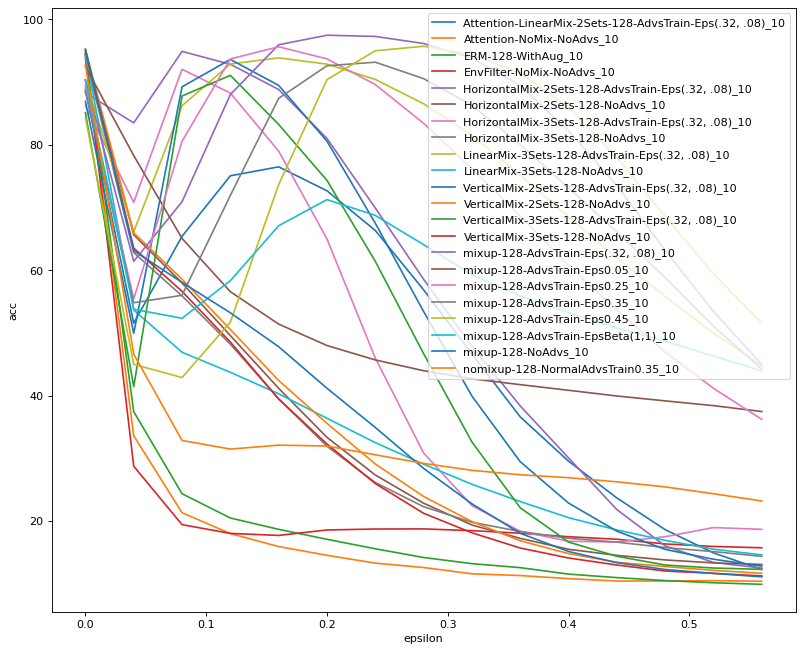

In [43]:
from matplotlib.pyplot import figure

figure(figsize=(12, 10), dpi=80)

plt.xlabel('epsilon'); plt.ylabel('acc');

legends = []
for name, err in errs.items():
    plt.plot(eps_list, to_acc_tensor(err))
    legends.append(name[7:])

plt.legend(legends)

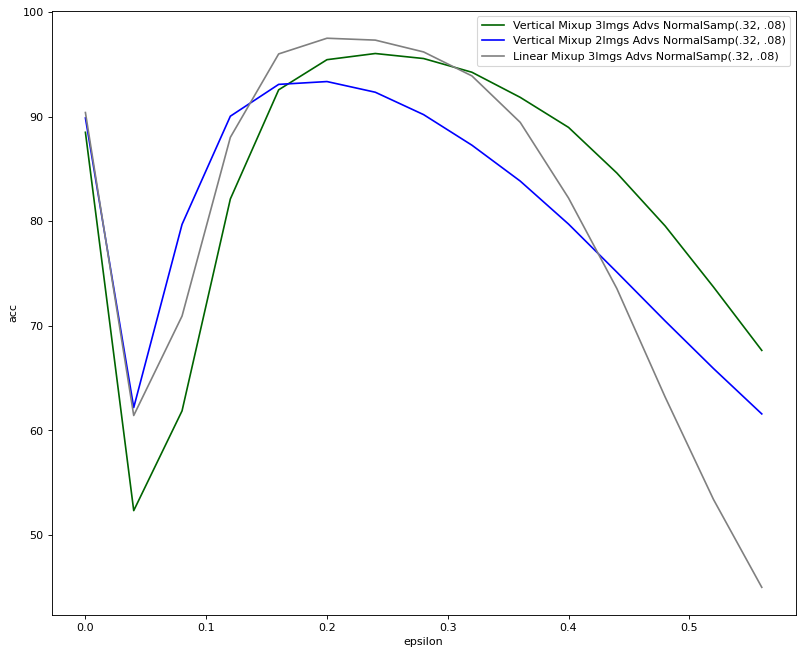

In [578]:
from matplotlib.pyplot import figure

figure(figsize=(12, 10), dpi=80)

plt.xlabel('epsilon'); plt.ylabel('acc');

plt.plot(eps_list, to_acc_tensor(err_testing_samp), c='darkgreen')
# plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08_Vertical_3samp), c='black')
# plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08_Vertical_2samp), c='gold')
plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08_linear_3samp), c='b')
plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08), c='gray')

plt.legend(['Vertical Mixup 3Imgs Advs NormalSamp(.32, .08)','Vertical Mixup 2Imgs Advs NormalSamp(.32, .08)','Linear Mixup 3Imgs Advs NormalSamp(.32, .08)', 'Mixup Advs 2Imgs NormalSamp(.32, .08)',])

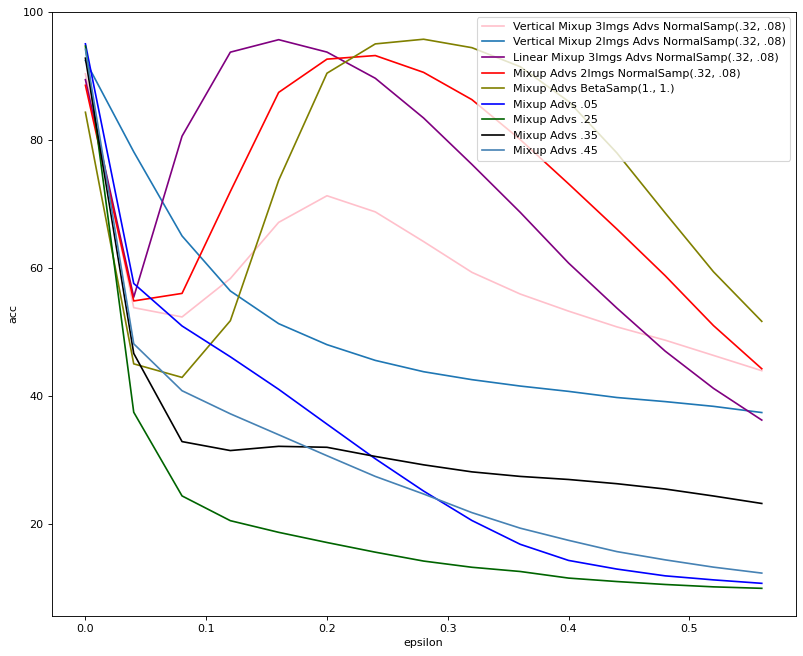

In [576]:
from matplotlib.pyplot import figure

figure(figsize=(12, 10), dpi=80)

plt.xlabel('epsilon'); plt.ylabel('acc');


# plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08_Vertical_3samp), c='peru')
# plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08_Vertical_2samp), c='olive')
# plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08_linear_3samp), c='gold')
plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08), c='gray')
plt.plot(eps_list, to_acc_tensor(err_SampEpsBeta_1_1), c='pink')
plt.plot(eps_list, to_acc_tensor(err05))
plt.plot(eps_list, to_acc_tensor(err25), c='purple')
plt.plot(eps_list, to_acc_tensor(err35), c='r')
plt.plot(eps_list, to_acc_tensor(err45), c='olive')
plt.plot(eps_list, to_acc_tensor(err_mixup), c='b')
plt.plot(eps_list, to_acc_tensor(err_erm_noadvs), c = 'darkgreen')
plt.plot(eps_list, to_acc_tensor(err_norm_advs), c='black')
plt.plot(eps_list, to_acc_tensor(err_NoAdvs_linear_3samp), c='steelblue')

plt.legend(['Vertical Mixup 3Imgs Advs NormalSamp(.32, .08)','Vertical Mixup 2Imgs Advs NormalSamp(.32, .08)','Linear Mixup 3Imgs Advs NormalSamp(.32, .08)', 'Mixup Advs 2Imgs NormalSamp(.32, .08)', 'Mixup Advs BetaSamp(1., 1.)', 'Mixup Advs .05', 'Mixup Advs .25', 'Mixup Advs .35', 'Mixup Advs .45', 'Vanilla Mixup', 'Vanilla Training', 'Normal Advs Training', 'Normal LinearMixup 3Imgs']);


In [164]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.imshow(npimg)
    plt.show()

In [654]:
while './Mixing-Augmentation/filters/attention' in sys.path:
    sys.path.remove('./Mixing-Augmentation/filters/attention')
    
sys.path

['/home/m25dehgh/testing_codes/NNs/Mixing-Augmentation/Adversarially-training-mixed',
 '/home/m25dehgh/anaconda3/envs/hugging/lib/python38.zip',
 '/home/m25dehgh/anaconda3/envs/hugging/lib/python3.8',
 '/home/m25dehgh/anaconda3/envs/hugging/lib/python3.8/lib-dynload',
 '',
 '/home/m25dehgh/anaconda3/envs/hugging/lib/python3.8/site-packages',
 '/home/m25dehgh/anaconda3/envs/hugging/lib/python3.8/site-packages/IPython/extensions',
 '/home/m25dehgh/.ipython']

In [21]:
!cd $baseAddr

/bin/bash: line 0: cd: ./Mixing-Augmentation.filters.attention.filter_code: No such file or directory


In [53]:



# loading model


masked_imgs.shape

Model Complete
torch.Size([128, 3, 32, 32])
<class 'str'>


torch.Size([128, 3, 32, 32])

In [ ]:
function = importlib.import_module("Mixing-Augmentation.filters.Environment")

masked_imgs = attention_mask_filter(torch.rand(10,3,32,32), payload={'model':CAM_cifar10,'mean':(0.4914, 0.4822, 0.4465),'std':(0.2023, 0.1994, 0.2010)})

masked_imgs.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true labels is 1 
 adversaliral predicted is tensor([6]) 
 nomral is predictedtensor([1])


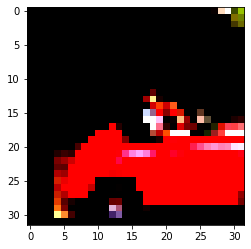

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


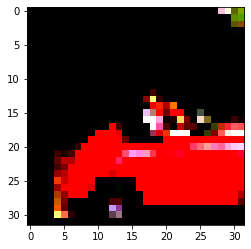

In [186]:
epsilon = .11
i = random.randint(0,100)
# i = 1


normal_inpt = trainset[i][0].reshape(1,3,32,32).cuda()
normal_inpt.requires_grad_(True)
out = net(normal_inpt)

target = torch.tensor([trainset[i][1]]).cuda()

loss = criterion(out, target)

optimizer.zero_grad()
loss.backward()

with torch.no_grad():
    advers_inp = normal_inpt + (epsilon * normal_inpt.grad.sign())
    advers_out = net(advers_inp)
    normal_out = net(normal_inpt)
    _,advs_predicted = torch.max(advers_out.cpu().data, 1)
    _,normal_predicted = torch.max(normal_out.cpu().data, 1)
    
print(f'true labels is {target.item()} \n adversaliral predicted is {advs_predicted} \n nomral is predicted{normal_predicted}')

imshow(normal_inpt.cpu().detach().squeeze())
imshow(advers_inp.cpu().detach().squeeze())

In [264]:
# advers_out = net(advers_inp) #+ (epsilon * normal_inpt.grad.sign())
# print(advers_out)
mx = 100
for j in range(1000):
    i = random.randint(0,3000)
    if torch.min(torch.min(trainset[i][0], -1)[0], -1)[0][0] < mx:
        mx = torch.min(torch.min(trainset[i][0], -1)[0], -1)[0][0]
mx

tensor(-2.4291)

In [ ]:
import pandas as pd

df = pd.read_csv("~/testing_codes/NNs/results/log_ResNet_ERM-128-WithAug_10.csv")
df